In [37]:
install.packages('dendextend', repos='http://cran.us.r-project.org')

Installing package into 'C:/Users/Tom/Documents/R/win-library/3.3'
(as 'lib' is unspecified)


package 'dendextend' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\Tom\AppData\Local\Temp\Rtmpm0JLKj\downloaded_packages


In [1]:
library(dendextend)

Warning message:
"package 'dendextend' was built under R version 3.3.3"
---------------------
Welcome to dendextend version 1.5.2
Type citation('dendextend') for how to cite the package.

Type browseVignettes(package = 'dendextend') for the package vignette.
The github page is: https://github.com/talgalili/dendextend/

Suggestions and bug-reports can be submitted at: https://github.com/talgalili/dendextend/issues
Or contact: <tal.galili@gmail.com>

	To suppress this message use:  suppressPackageStartupMessages(library(dendextend))
---------------------


Attaching package: 'dendextend'

The following object is masked from 'package:stats':

    cutree



In [2]:
ts.j <- read.csv('c:/users/tom/pycharmprojects/nyu-research/data/series/alc-june.csv')
ts.s <- read.csv('c:/users/tom/pycharmprojects/nyu-research/data/series/alc-sept.csv')

In [15]:
nsample <- sum(ts.j$total)

In [25]:
nsample*0.25

[1] 9438985

In [3]:
boot <- function(ts, perc=1){
    new_ts <- ts
    new_ts$total <- 0
    total <- rmultinom(n=1, size=floor(nsample*perc), prob=ts$total)
    new_ts[,4] <- total
    for (i in 1:nrow(ts)){
        new_ts[i, 3] <- unname(rmultinom(n=1, size=total[i], prob=ts[i, c(3,4)]))[1]
    }
    new_ts
    }

In [4]:
source("C:/Users/Tom/PycharmProjects/nyu-research/ts.R")

Warning message:
"package 'zoo' was built under R version 3.3.3"
Attaching package: 'zoo'

The following objects are masked from 'package:base':

    as.Date, as.Date.numeric

Warning message:
"package 'forecast' was built under R version 3.3.3"

In [5]:
library('TSclust')
library('factoextra')

Warning message:
"package 'TSclust' was built under R version 3.3.3"Loading required package: wmtsa
Warning message:
"package 'wmtsa' was built under R version 3.3.3"Loading required package: pdc
Warning message:
"package 'pdc' was built under R version 3.3.3"Loading required package: cluster
Warning message:
"package 'factoextra' was built under R version 3.3.3"Loading required package: ggplot2
Warning message:
"package 'ggplot2' was built under R version 3.3.3"

In [24]:

preprocessing <- function(ts, thres=1000){
    df = time_index(data.frame(ts[,1:3]))
    df_total = time_index(data.frame(ts[,c(1,2,4)]))
    missing = df_total[, "tweets"] < thres
    df_total[missing, "tweets"] <- NA
    df[missing, ] <- NA
    df_total = na.locf(df_total[, "tweets"])
    df_filled = (na.locf(df[, ncol(df)]))
    return(list(series = df_filled, total = df_total))
}

In [7]:
generate_plots <- function(boot.j, boot.s, simnum){
        
    june <- preprocessing(boot.j)
    june_cas = ts(june$series[33:(672+32)], frequency=24)
    june_tot = ts(june$total[33:(672+32)], frequency=24)
    june_perc <- june_cas/june_tot

    sept = preprocessing(boot.s)
    sept_cas = ts(sept$series[9:(672+8)], frequency=24)
    sept_tot = ts(sept$total[9:(672+8)], frequency=24)
    sept_perc <- sept_cas/sept_tot

    sept_days = split_by_day(sept_perc)
    colnames(sept_days) = c(1:28)
    june_days = split_by_day(june_perc)
    colnames(june_days) = c(102:129)
    combined = cbind(june_days, sept_days)

    phase_diss = dissimilarity(as.matrix(combined), phase_dist(1))
    weekdays = c(rep(c('Tu', 'W' ,'Th', 'F', 'Sa', 'Su', 'M'), 4), c('Tu', 'W' ,'Th', 'F', 'Sa', 'Su', 'M(L)'),
                 rep(c('Tu', 'W' ,'Th', 'F', 'Sa', 'Su', 'M'), 3))
    dist = phase_diss
    colnames(dist)=weekdays
    rownames(dist)=weekdays
    a=agnes(dist, diss=TRUE)

    
    p <- fviz_dend(a,  k=2, main='', ylab='Height', xlab='Day', las=1, cex=1.2, cex.lab=1.5, horiz=TRUE, label_col='black')
    # mtext( text='Day of Week', side=2, cex=1.5)
    p <- p + theme(axis.title=element_text(size=14,face="bold")) 
    
    
    # ggsave(filename=paste('c:/users/tom/documents/research/bootstrap/phase-sim-', simnum, '.pdf', sep=""),device='pdf')
    colnames(combined)=weekdays
    dist = diss(combined, METHOD='EUCL')

    b = agnes(dist, diss=TRUE)
    
    p2 <- fviz_dend(b, k=4, k_colors=c("#ff6666", "#33cccc",'#66ff66', '#cc66ff'), main='', ylab='Height', xlab='Day', label_col='black', las=1, cex=1.2, cex.lab=1.5, horiz=TRUE)
    p2 <- p2 + theme(axis.title=element_text(size=14,face="bold"))
    
    return (list(as.dendrogram(a), as.dendrogram(b)))
    
    # ggsave(filename=paste('c:/users/tom/documents/research/bootstrap/euc-sim-', simnum, '.pdf', sep=""),device='pdf')
}

In [47]:
n = 100
results.b.p <- numeric(30)
results.b.e <- numeric(30)
results.c.p <- numeric(30)
results.c.e <- numeric(30)
for (i in 1:30){
    p <- 0.1 + 0.03*i
    cor.b.phase <- c()
    cor.b.euc <- c()
    cor.c.phase <- c()
    cor.c.euc <- c()
    for (samp in 1:n)
    {
        boot.j <- boot(ts.j, perc=p)
        boot.s <- boot(ts.s, perc=p)
        x1 <- generate_plots(boot.j, boot.s, simnum=0)
        
        boot.j <- boot(ts.j, perc=p)
        boot.s <- boot(ts.s, perc=p)
        x2 <- generate_plots(boot.j, boot.s, simnum=0)
        phase.dl <- dendlist(x1[[1]], x2[[1]])
        euc.dl <- dendlist(x1[[2]], x2[[2]])
        cor.b.phase <- c(cor.b.phase, cor.dendlist(phase.dl, method='baker'))
        cor.c.phase <- c(cor.c.phase, cor.dendlist(phase.dl, method='cophenetic'))
        cor.b.euc <- c(cor.b.euc, cor.dendlist(euc.dl, method='baker'))
        cor.c.euc <- c(cor.c.euc, cor.dendlist(euc.dl, method='cophenetic'))
        
    }
    results.b.p[i] <- mean(cor.b.phase)
    results.b.e[i] <- mean(cor.b.euc)
    results.c.p[i] <- mean(cor.c.phase)
    results.c.e[i] <- mean(cor.c.euc)
}


In [53]:
write.table(results.b.p, 'c:/users/tom/documents/research/sensitivity/baker-phase.csv', sep=',')
write.table(results.b.e, 'c:/users/tom/documents/research/sensitivity/baker-euc.csv', sep=',')

write.table(results.c.p, 'c:/users/tom/documents/research/sensitivity/c-phase.csv', sep=',')
write.table(results.c.e, 'c:/users/tom/documents/research/sensitivity/c-euc.csv', sep=',')


Saving 6.67 x 6.67 in image


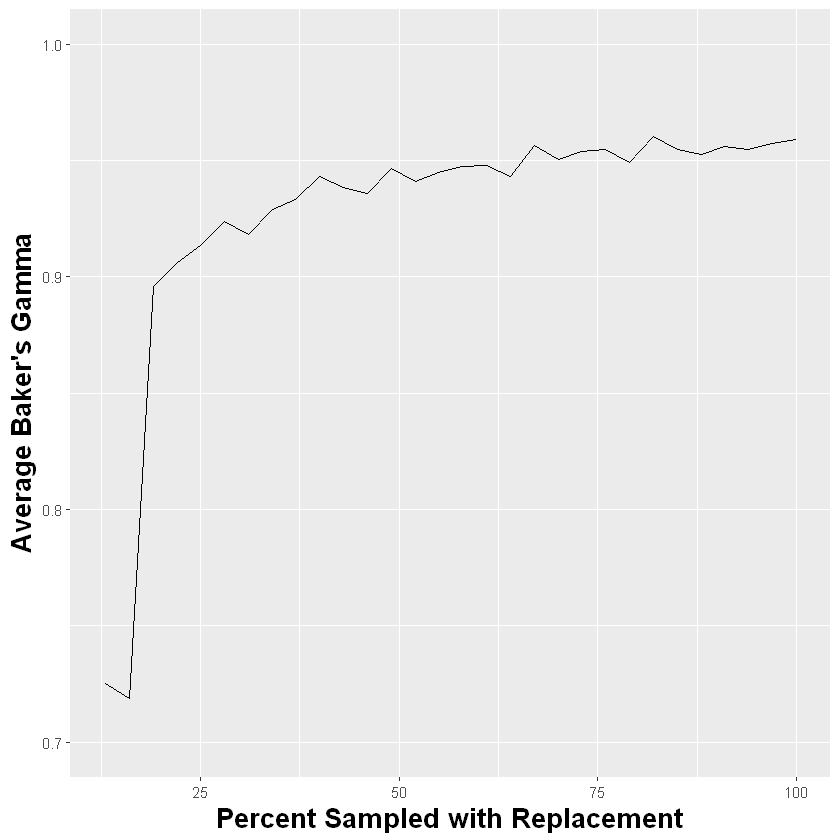

In [90]:
# Baker Correlation, Phase dendrogram
b.p <- data.frame(x=seq(from=13, to= 100, by=3), y=results.b.p)
ymax= results.b.p + 0.01
ymin = results.b.p - 0.01
ggplot(b.p, aes(x=x, y=y)) + geom_line() +xlab('Percent Sampled with Replacement') +ylab("Average Baker's Gamma")+ ylim(c(0.7,1)) +theme(axis.title=element_text(size=16,face="bold"))
#+ geom_ribbon(aes(ymin=ymin, ymax=ymax),  fill="blue", alpha="0.3")
ggsave('c:/users/tom/documents/research/sensitivity/baker-phase.pdf')

Saving 6.67 x 6.67 in image


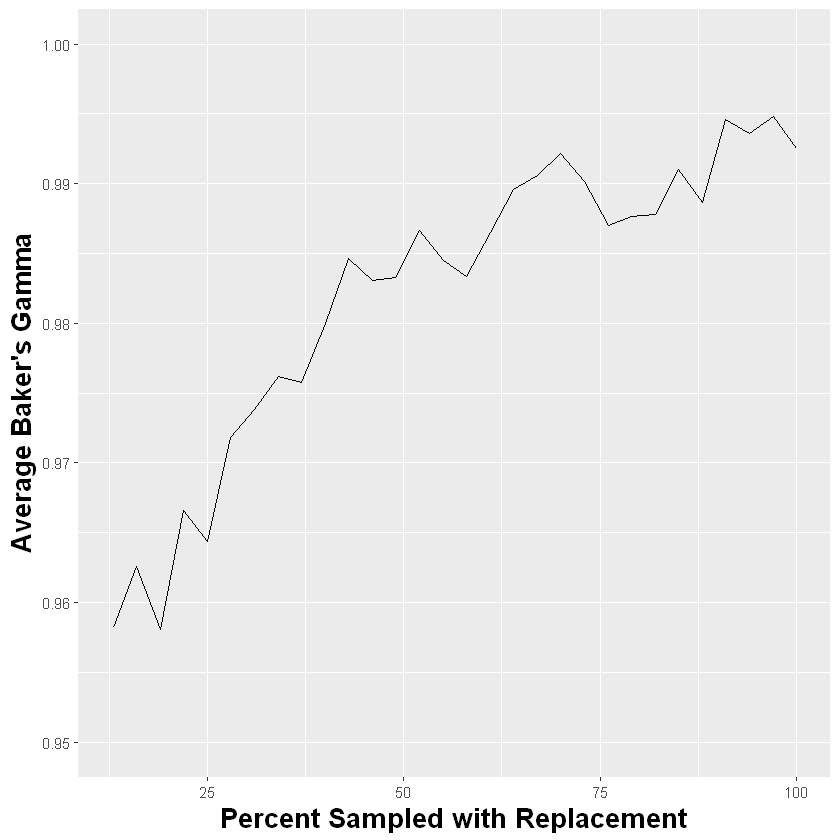

In [88]:
# Baker correlation, Euclidean Dendrogram
b.e <- data.frame(x=seq(from=13, to= 100, by=3), y=results.b.e)
ymax= results.b.p + 0.01
ymin = results.b.p - 0.01
ggplot(b.e, aes(x=x, y=y)) + geom_line() +xlab('Percent Sampled with Replacement') +ylab("Average Baker's Gamma")+ ylim(c(0.95,1))+theme(axis.title=element_text(size=16,face="bold"))
#+ geom_ribbon(aes(ymin=ymin, ymax=ymax),  fill="blue", alpha="0.3")
ggsave('c:/users/tom/documents/research/sensitivity/baker-euc.pdf')

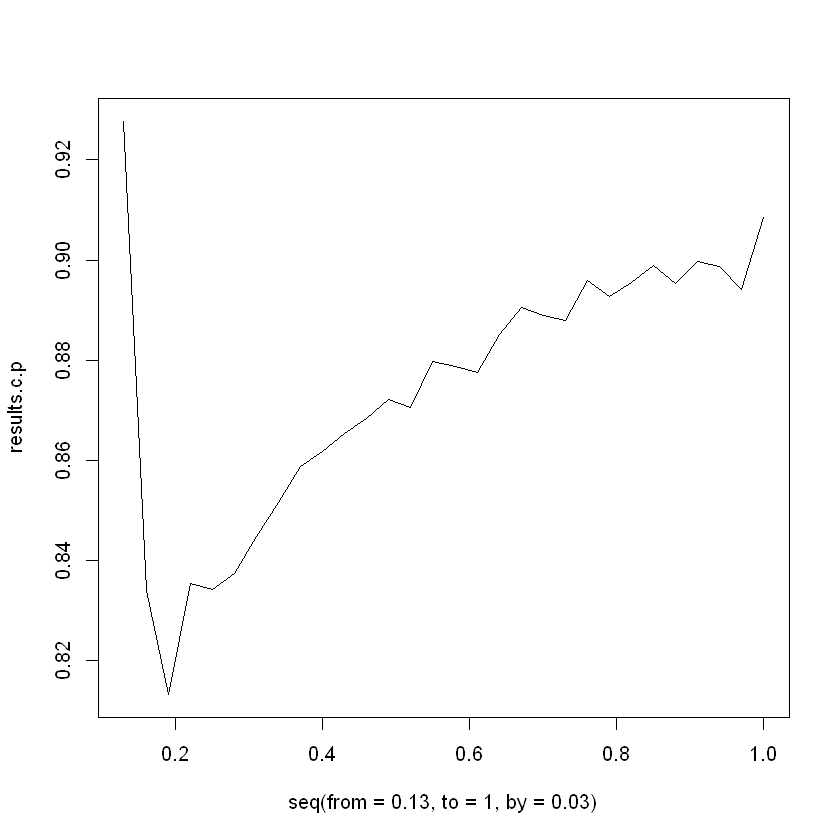

In [49]:
# cophenetic correlation, phase dendrogram
plot(seq(from=0.13, to= 1, by=0.03), results.c.p, type='l')

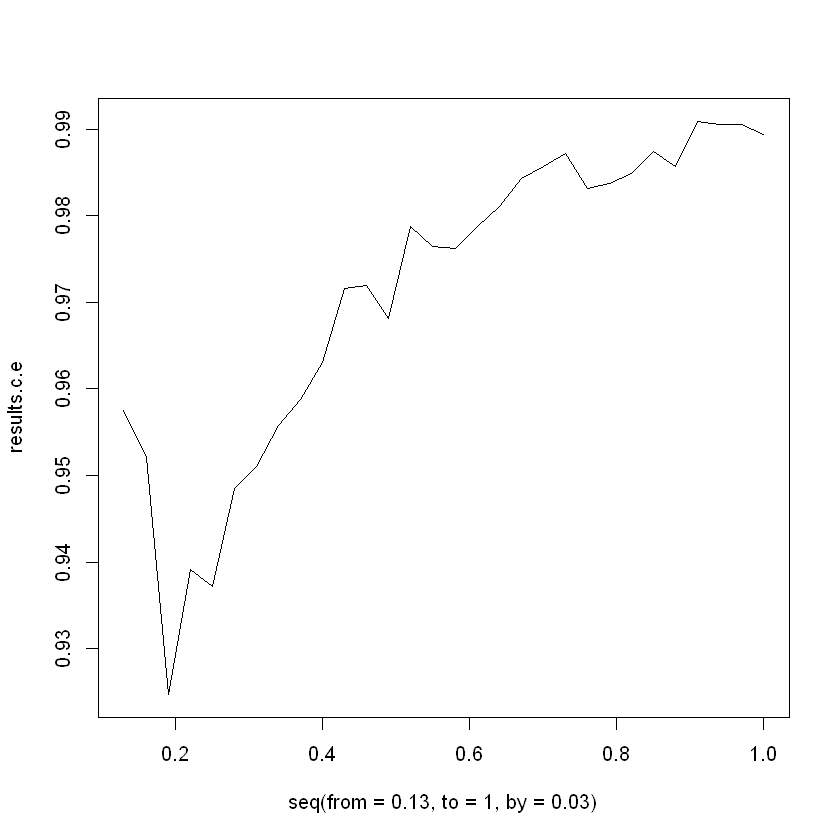

In [51]:
# cophenetic correlation, euclidean dendrogram
plot(seq(from=0.13, to= 1, by=0.03), results.c.e, type='l')

In [63]:
d.phase <- dendlist()
d.euc <- dendlist()
for (i in 1:10){
    boot.j <- boot(ts.j, perc=0.15)
    boot.s <- boot(ts.s, perc=0.15)
    write.table(boot.j ,paste('c:/users/tom/documents/research/bootstrap/june-boot', i, '.csv', sep=""), sep=',')
    write.table(boot.j ,paste('c:/users/tom/documents/research/bootstrap/sept-boot', i, '.csv', sep=""), sep=',')
    x <- generate_plots(boot.j, boot.s, simnum=i)
    print(typeof(x[1]))
    d.phase <- d.phase %>% dendlist(x[[1]])
    d.euc <- d.euc %>% dendlist(x[[2]])

}

 [1]   1   2   3   4   5   6   7   8  25  26  27  28  29  30  31  32 721 722 723
[20] 724
 [1] 408 409 410 411 412 413 414 415 476 477 478 479 484 485 486 721 722 723 724
[20] 725
[1] "list"
 [1]   1   2   3   4   5   6   7   8  25  26  27  28  29  30  31  32  33 721 722
[20] 723 724
 [1] 408 409 410 411 412 413 414 415 476 477 478 479 484 485 486 721 722 723 724
[20] 725
[1] "list"
 [1]   1   2   3   4   5   6   7   8  25  26  27  28  29  30  31  32  33 721 722
[20] 723 724
 [1] 408 409 410 411 412 413 414 415 476 477 478 479 484 485 486 721 722 723 724
[20] 725
[1] "list"
 [1]   1   2   3   4   5   6   7   8   9  25  26  27  28  29  30  31  32  33 721
[20] 722 723 724
 [1] 408 409 410 411 412 413 414 415 476 477 478 479 484 485 486 721 722 723 724
[20] 725
[1] "list"
 [1]   1   2   3   4   5   6   7   8  25  26  27  28  29  30  31  32 721 722 723
[20] 724
 [1] 408 409 410 411 412 413 414 415 476 477 478 479 484 485 486 721 722 723 724
[20] 725
[1] "list"
 [1]   1   2   3   4   5   6 

In [66]:
cor.dendlist(d.euc, method='cophenetic')

1.0000000,0.9441955,0.9045241,0.8942893,0.9481747,0.9395874,0.9760172,0.9511106,0.9393393,0.9326738
0.9441955,1.0000000,0.9131516,0.9209249,0.9629083,0.9691267,0.9462975,0.9772550,0.9713032,0.9649216
0.9045241,0.9131516,1.0000000,0.8636972,0.8969751,0.9001560,0.8917032,0.9079127,0.9175676,0.9019623
0.8942893,0.9209249,0.8636972,1.0000000,0.9315907,0.9079461,0.9036659,0.9216133,0.9200689,0.9042785
0.9481747,0.9629083,0.8969751,0.9315907,1.0000000,0.9552764,0.9449888,0.9692214,0.9638667,0.9676383
0.9395874,0.9691267,0.9001560,0.9079461,0.9552764,1.0000000,0.9508930,0.9829718,0.9717331,0.9784776
0.9760172,0.9462975,0.8917032,0.9036659,0.9449888,0.9508930,1.0000000,0.9618934,0.9478883,0.9317511
0.9511106,0.9772550,0.9079127,0.9216133,0.9692214,0.9829718,0.9618934,1.0000000,0.9808748,0.9751244
0.9393393,0.9713032,0.9175676,0.9200689,0.9638667,0.9717331,0.9478883,0.9808748,1.0000000,0.9697336
0.9326738,0.9649216,0.9019623,0.9042785,0.9676383,0.9784776,0.9317511,0.9751244,0.9697336,1.0000000


In [68]:
cor.dendlist(d.euc, method='baker')

1.0000000,0.9830718,0.9936497,0.9187315,0.9187757,0.9855795,0.9694443,0.9073577,0.9115775,0.9747162
0.9830718,1.0000000,0.9869371,0.9424571,0.9429182,0.9711988,0.9704296,0.9319277,0.9430493,0.9858729
0.9936497,0.9869371,1.0000000,0.9308986,0.9282170,0.9932354,0.9578575,0.9099063,0.9211368,0.9785833
0.9187315,0.9424571,0.9308986,1.0000000,0.9995369,0.9098374,0.9294554,0.9606318,0.9284183,0.9494572
0.9187757,0.9429182,0.9282170,0.9995369,1.0000000,0.9055085,0.9329704,0.9630862,0.9288812,0.9499183
0.9855795,0.9711988,0.9932354,0.9098374,0.9055085,1.0000000,0.9355203,0.8989496,0.9062208,0.9529021
0.9694443,0.9704296,0.9578575,0.9294554,0.9329704,0.9355203,1.0000000,0.8961539,0.9262772,0.9704296
0.9073577,0.9319277,0.9099063,0.9606318,0.9630862,0.8989496,0.8961539,1.0000000,0.9390020,0.9197969
0.9115775,0.9430493,0.9211368,0.9284183,0.9288812,0.9062208,0.9262772,0.9390020,1.0000000,0.9394915
0.9747162,0.9858729,0.9785833,0.9494572,0.9499183,0.9529021,0.9704296,0.9197969,0.9394915,1.0000000
